In [2]:
import numpy as np
from lib.pde_find import PDEFind
from IPython.display import display, Math
from lib.utils.create_gif import create_gif

<Figure size 640x480 with 0 Axes>

In [3]:
raw_data = np.load("data/3.npz")

u = raw_data["u"]
v = raw_data["v"]
x = raw_data["x"]
y = raw_data["y"]
t = raw_data["t"]

In [4]:
pdefind = PDEFind(
    var_labels=(["x", "y", "t"], ["u", "v"]),
    polynomial_degree=3,
    order=2,
    periodic=True,
)

In [5]:
u, v, x, y, t = pdefind.subsample_data(u, v, x, y, t, factors=[2, 2, 2])


In [6]:
grids = pdefind.add_grid(x, y, t)

In [7]:
# only consider terms that have one derivative
term_regex = r"^(u|v)*(_{(x|y)+})?(v)*$"

library, labels = pdefind.create_library(u, v, term_regex=term_regex)

display(Math(r"\\".join(labels)))

<IPython.core.display.Math object>

In [8]:
u_t = np.gradient(u, pdefind.time_grid, axis=-1)
v_t = np.gradient(v, pdefind.time_grid, axis=-1)

In [9]:
algorithm = "tlsq"
cutoff = 1e-4
iterations = 500
max_terms = 10

In [10]:
coef_u, alpha_u = pdefind.solve_regression(
    library,
    u_t,
    algorithm=algorithm,
    cutoff=cutoff,
    iterations=iterations,
    num_term_limit=max_terms,
)

Solving using tlsq regression
Library size: (69, 128, 128, 101), Target size: 1654784


TLSQ Iterations:  23%|██▎       | 117/500 [01:51<06:06,  1.05it/s, #nzz_terms=8, cutoff=0.0001] 

# of non-zero terms: 8


In [11]:
display(Math(pdefind.latex_string(coef_u, labels, "u")))

<IPython.core.display.Math object>

In [13]:
coef_v, alpha_v = pdefind.solve_regression(
    library,
    v_t,
    algorithm=algorithm,
    cutoff=cutoff,
    iterations=iterations,
    num_term_limit=max_terms,
)

Solving using tlsq regression
Library size: (69, 128, 128, 101), Target size: 1654784


TLSQ Iterations:  22%|██▏       | 109/500 [02:02<07:17,  1.12s/it, #nzz_terms=8, cutoff=0.0001] 

# of non-zero terms: 8


In [14]:
display(Math(pdefind.latex_string(coef_v, labels, "v")))

<IPython.core.display.Math object>

In [16]:
initial_conditions = [u[..., 0], v[..., 0]]
coefficients = [coef_u, coef_v]

u_pred, v_pred = pdefind.solve(initial_conditions, coefficients, labels)

0
The solver successfully reached the end of the integration interval.


In [17]:
l2_err_u = np.linalg.norm(u - u_pred) / np.linalg.norm(u)
l2_err_v = np.linalg.norm(v - v_pred) / np.linalg.norm(v)

print(f"L2 error for u: {l2_err_u:.3e}")
print(f"L2 error for v: {l2_err_v:.3e}")

l2_err_u = np.linalg.norm(u[..., -1] - u_pred[..., -1]) / np.linalg.norm(u[..., -1])
l2_err_v = np.linalg.norm(v[..., -1] - v_pred[..., -1]) / np.linalg.norm(v[..., -1])

print(f"L2 error (final_t) for u: {l2_err_u:.3e}")
print(f"L2 error (final_t) for v: {l2_err_v:.3e}")

L2 error for u: 4.173e-01
L2 error for v: 4.173e-01
L2 error (final_t) for u: 5.231e-01
L2 error (final_t) for v: 5.231e-01


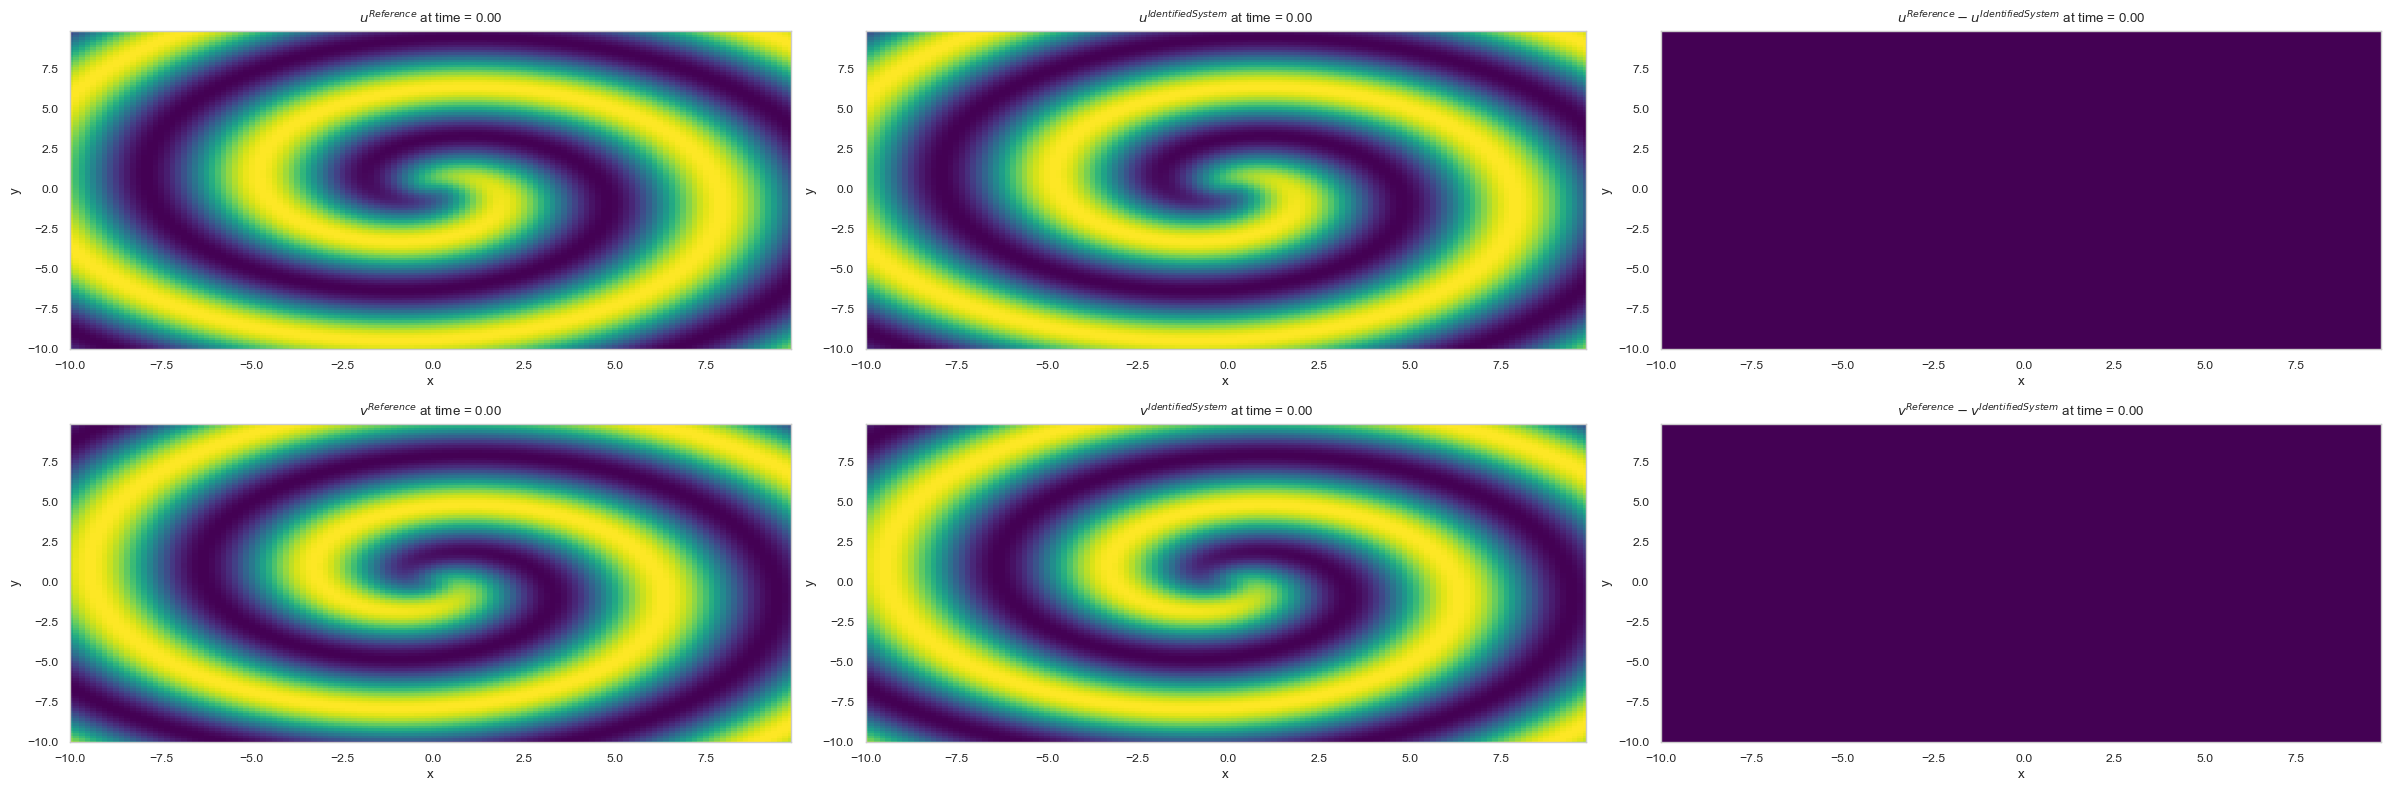

In [18]:
create_gif(x, y, pdefind.time_grid, u, v, u_pred, v_pred, "pde3.gif")

If you can't see the plot below see the file `pde3.gif` for a gif animation of the reference solution and the identified solution.

<!-- Show gif image -->
![image](figures/pde3.gif)